In [1]:
!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py

--2021-07-15 06:15:09--  https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6371 (6.2K) [text/plain]
Saving to: ‘pytorchcv.py’

pytorchcv.py        100%[===================>]   6.22K  --.-KB/s    in 0s      

2021-07-15 06:15:09 (56.4 MB/s) - ‘pytorchcv.py’ saved [6371/6371]



In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import pytorchcv
pytorchcv.load_mnist()

# what "pytorchcv.load_mnist()" does:
#
# import builtins  # create built-in directly callable name from import module (no need to add pytorchcv. before calling it)
# batch_size=64
# builtins.data_train = torchvision.datasets.MNIST('./data',
#     download=True,train=True,transform=ToTensor())
# builtins.data_test = torchvision.datasets.MNIST('./data',
#     download=True,train=False,transform=ToTensor())
# builtins.train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
# builtins.test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),  # 784(=28*28) inputs, 10 outputs
    nn.LogSoftmax())  # log(softmax(logits)), combine log part in cross-entropy-loss with softmax layer

In [4]:
print(f"Digit to be predicted: {data_train[0][1]}")
torch.exp(net(data_train[0][0]))  # take exp(outputs) to turn net's output into actual probabilities

Digit to be predicted: 5


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.0873, 0.1044, 0.1324, 0.0759, 0.0995, 0.1229, 0.0948, 0.0973, 0.0991,
         0.0864]], grad_fn=<ExpBackward>)

In [5]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=64)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=64)  # we can use larger batch size for testing

In [6]:
def train_epoch(net, dataloader, lr=0.01, optimizer=None, loss_fn=nn.NLLLoss()):  # NLLLoss: cross-entropy-loss without log
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)  # or: return first argument if both arguments are not None
    net.train()  # nn.Module default train(mode=True), but still, it is safer to specify explicitly
    total_loss, acc, count = 0, 0, 0
    for features, labels in dataloader:
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out, labels)  # NLLLoss(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, dim=1)
        acc += (predicted == labels).sum()
        count += len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net, train_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(0.005942207336425781, 0.8926333333333333)

In [7]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for features, labels in dataloader:
            out = net(features)
            loss += loss_fn(out, labels)
            pred = torch.max(out, dim=1)[1]
            acc += (pred == labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net, test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


(0.005868122482299805, 0.8939)

In [8]:
def train(net, train_loader, test_loader, optimizer=None, lr=0.01, epochs=10, loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}  # history to plot loss and accuracy
    for ep in range(epochs):
        tl, ta = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        vl, va = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Eposh {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res["train_loss"].append(tl)
        res["train_acc"].append(ta)
        res["val_loss"].append(vl)
        res["val_acc"].append(va)
    return res

# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

hist = train(net, train_loader, test_loader, epochs=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Eposh  0, Train acc=0.893, Val acc=0.894, Train loss=0.006, Val loss=0.006
Eposh  1, Train acc=0.910, Val acc=0.899, Train loss=0.005, Val loss=0.006
Eposh  2, Train acc=0.913, Val acc=0.898, Train loss=0.005, Val loss=0.006
Eposh  3, Train acc=0.915, Val acc=0.897, Train loss=0.005, Val loss=0.006
Eposh  4, Train acc=0.916, Val acc=0.897, Train loss=0.005, Val loss=0.006


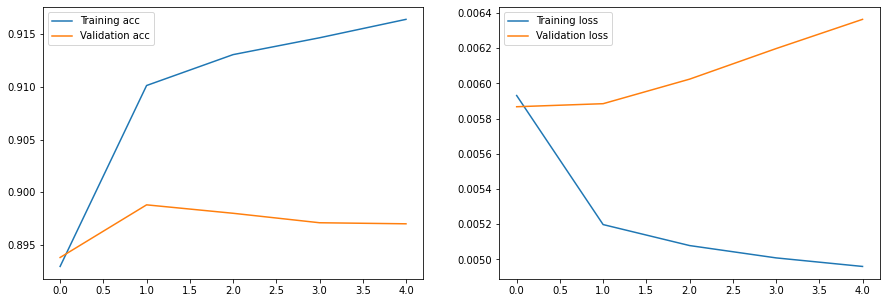

In [9]:
plt.figure(figsize=(15, 5))  # create a figure
plt.subplot(121)  # three-digits integer 121: 1=nrows, 2=ncols, and 3=index
plt.plot(hist["train_acc"], label="Training acc")
plt.plot(hist["val_acc"], label="Validation acc")
plt.legend()
plt.subplot(122)
plt.plot(hist["train_loss"], label="Training loss")
plt.plot(hist["val_loss"], label="Validation loss")
plt.legend()

In [10]:
# net.state_dict()['1.weight'].size() is [10, 784] ([out_dims, in_dims])

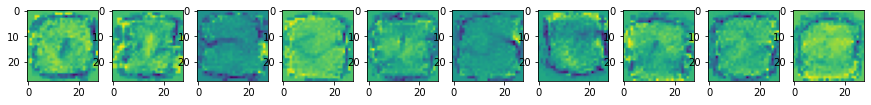

In [11]:
weight_tensor = next(net.parameters())
fig, ax = plt.subplots(1,10, figsize=(15, 4))  # Create a figure and a set of subplots
for i, x in enumerate(weight_tensor):  # digit i, x.shape=[784,]
    ax[i].imshow(x.view(28, 28).detach())  # detach(): Returns a new Tensor, detached from the current graph. The result will never require gradient.